In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
from tqdm.notebook import tqdm
from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
%config InlineBackend.figure_format = 'retina'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
transform = transforms.Compose(
    [
        transforms.ColorJitter(hue = 0.05, saturation = 0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

base_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

In [5]:
cifar_train = torchvision.datasets.CIFAR10(root = './cifar', train = True, download = True, transform = transform)
cifar_test = torchvision.datasets.CIFAR10(root = './cifar', train = False, download = True, transform = base_transform)

train_dataloader = torch.utils.data.DataLoader(cifar_train, batch_size = 40, shuffle = True, num_workers = 4)
test_dataloader = torch.utils.data.DataLoader(cifar_test, batch_size = 40, shuffle = False, num_workers = 4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
len(cifar_train)

50000

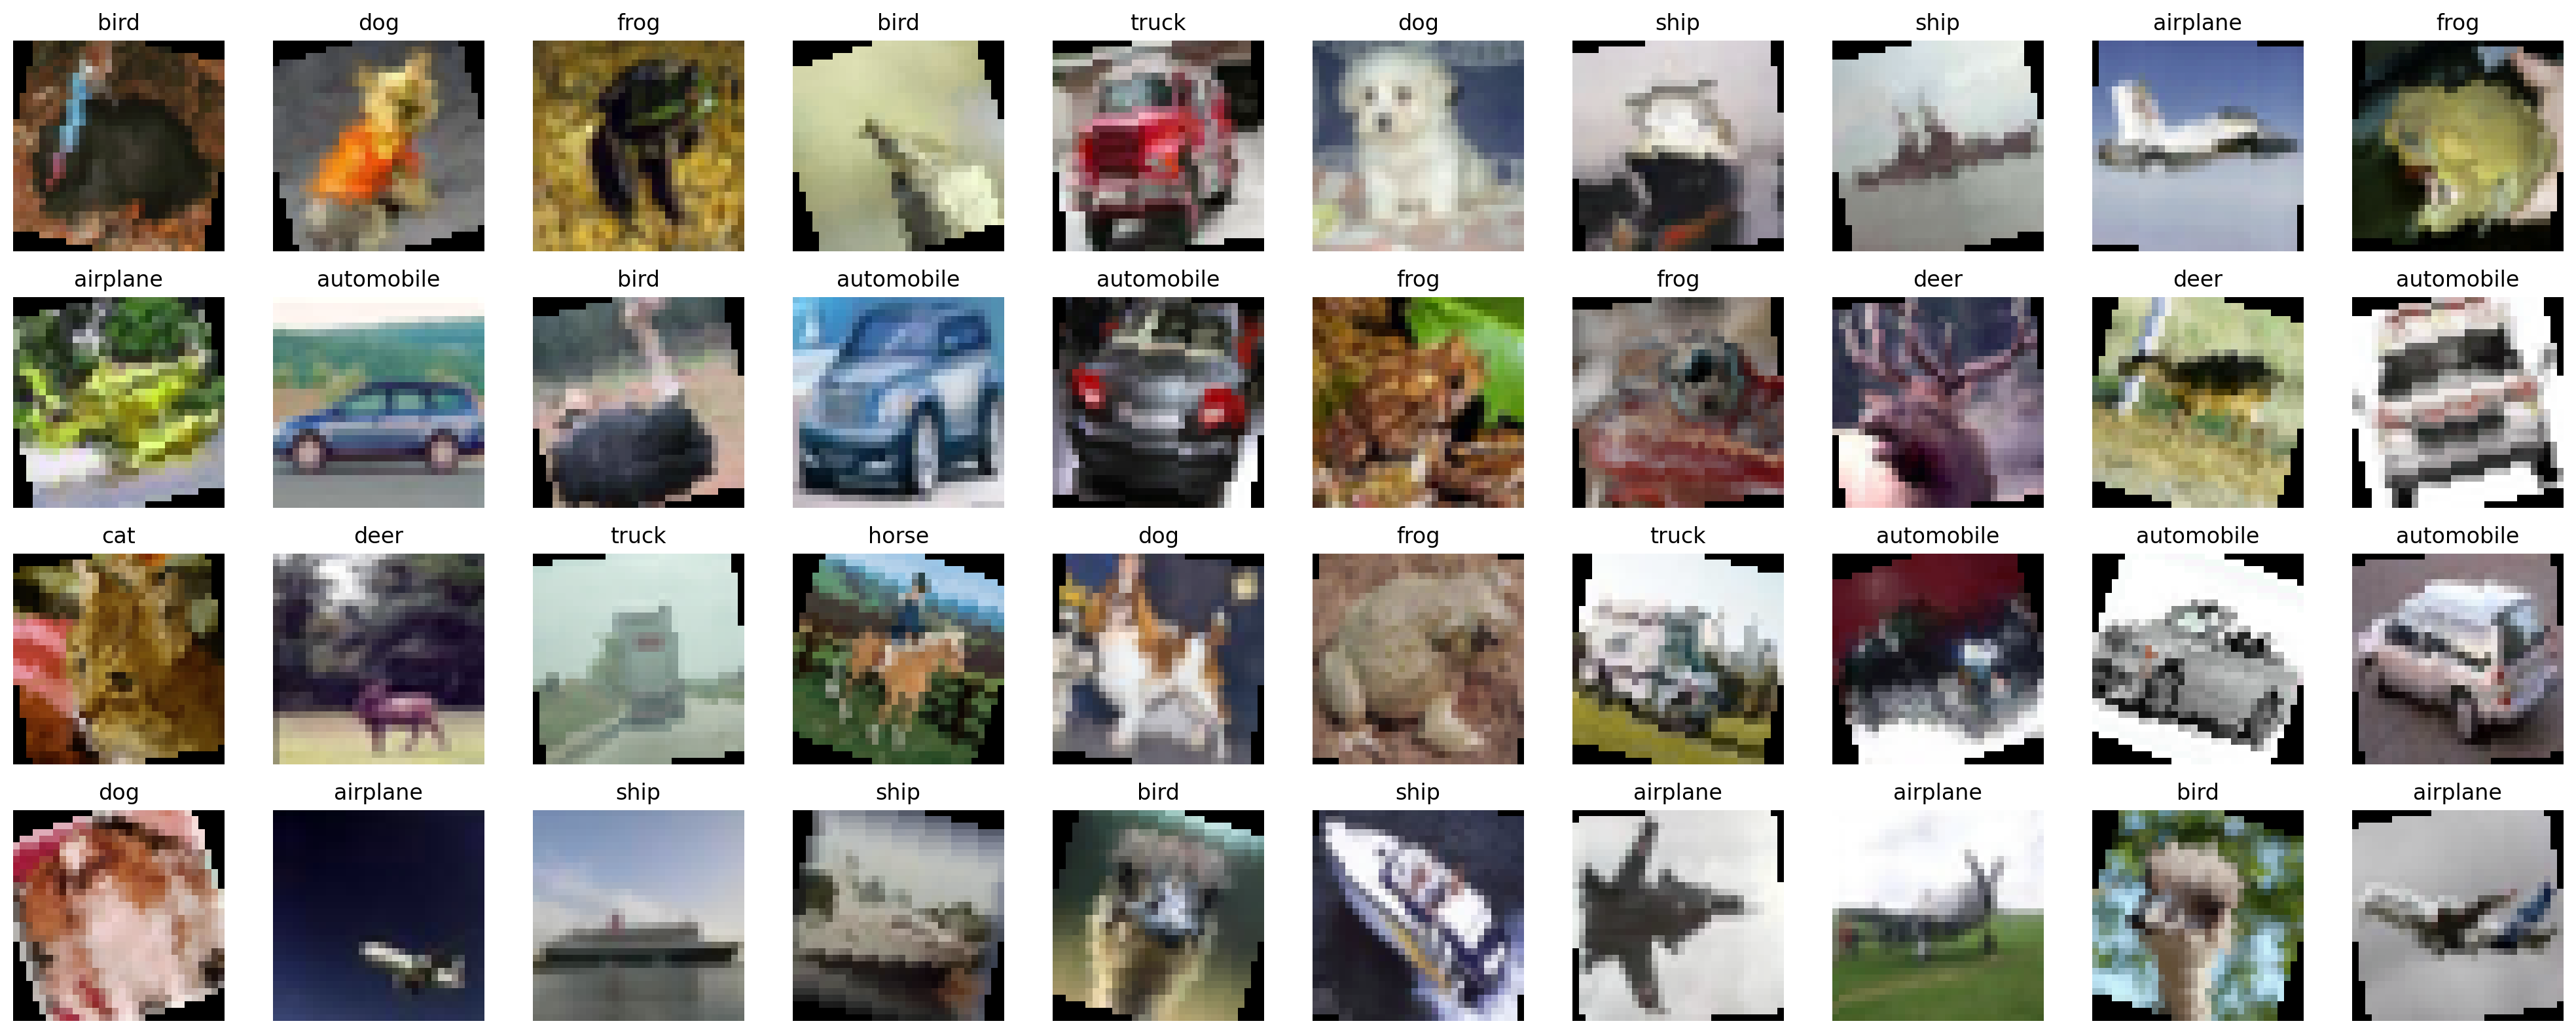

In [7]:
images, labels = next(iter(train_dataloader))
fig, axes = plt.subplots(4, 10, figsize = (20, 8))

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0)  # C, H, W -> H, W ,C
    img = img * torch.tensor((0.247, 0.243, 0.261)) + torch.tensor((0.4914, 0.4822, 0.4465))
    img = img.clamp(0, 1)
    ax.imshow(img)
    ax.set_title(classes[labels[i].item()])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
class VGG_Block(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = 1)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pooling(x)
        x = self.flatten(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [9]:
vgg_block = VGG_Block().to(device)

In [10]:
print(vgg_block)

VGG_Block(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
optimizer = optim.SGD(vgg_block.parameters(), lr = 0.001, momentum = 0.9)

In [12]:
def train(model, train_dataloader, val_dataloader, optimizer, device, epochs = 10):
    model.to(device)

    val_loss_history = [ ]
    val_acc_history = [ ]

    for epoch in range(epochs):
        model.train()
        for x_train, y_train in tqdm(train_dataloader, desc = f'Epoch {epoch + 1}/{epochs}'):
            y_pred = model(x_train.to(device))
            loss = F.cross_entropy(y_pred, y_train.to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 2 == 0:
            model.eval()
            val_loss = [ ]
            val_accuracy = [ ]

            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader, desc = 'Validation'):
                    y_pred = model(x_val.to(device))
                    loss = F.cross_entropy(y_pred, y_val.to(device))
                    val_loss.append(loss.item())

                    preds = torch.argmax(y_pred, dim = -1)
                    acc = (preds == y_val.to(device)).float().mean().item()
                    val_accuracy.append(acc)

            mean_loss = np.mean(val_loss)
            mean_acc = np.mean(val_accuracy)

            val_loss_history.append(mean_loss)
            val_acc_history.append(mean_acc)

            print(f'Epoch {epoch + 1}: validation loss = {mean_loss:.4f}, validation accuracy = {mean_acc:.4f}')

    plt.plot(val_loss_history, label = 'Validation Loss', color = 'red')
    plt.plot(val_acc_history, label = 'Validation Accuracy', color = 'green')
    plt.xlabel('Validation step')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

Training model with 528474 parameters


Epoch 1/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: validation loss = 1.5828, validation accuracy = 0.4369


Epoch 2/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: validation loss = 1.2890, validation accuracy = 0.5378


Epoch 4/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: validation loss = 1.1256, validation accuracy = 0.5975


Epoch 6/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: validation loss = 1.0383, validation accuracy = 0.6361


Epoch 8/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: validation loss = 0.9890, validation accuracy = 0.6563


Epoch 10/10:   0%|          | 0/1250 [00:00<?, ?it/s]

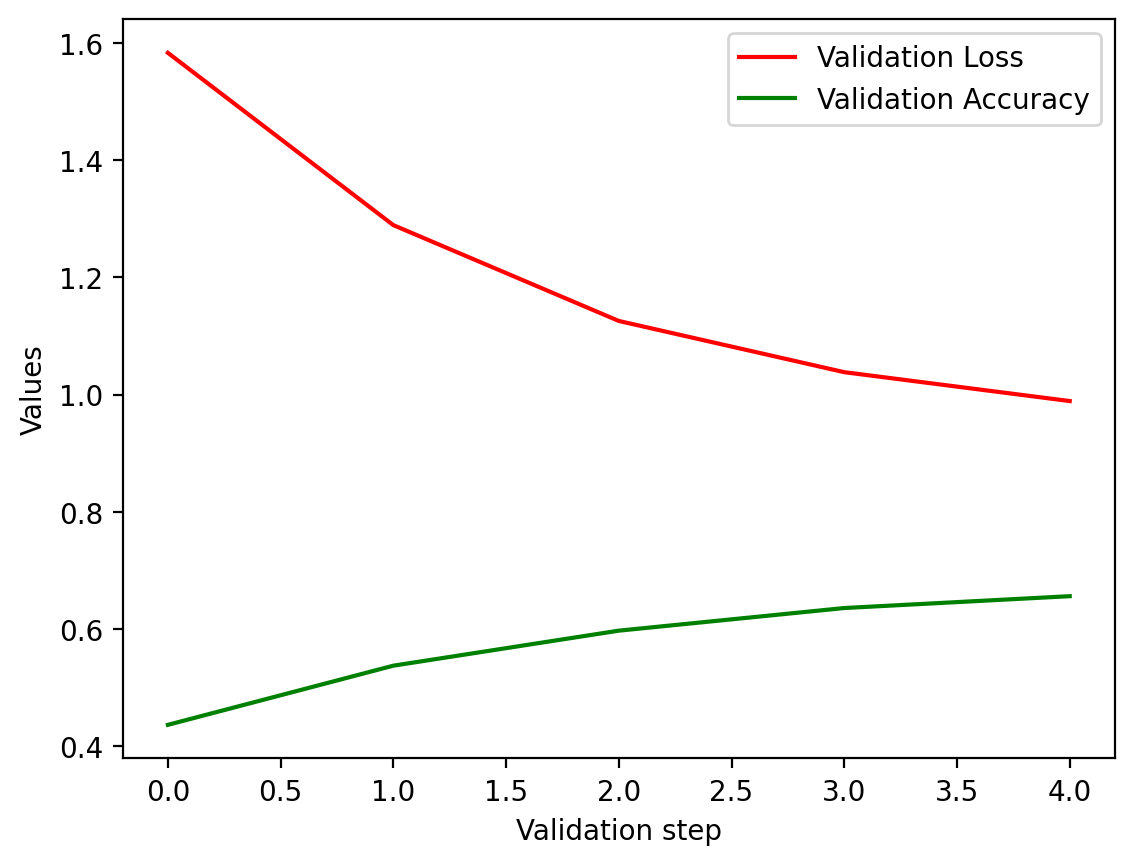

In [13]:
print(f'Training model with {sum([x[1].numel() for x in vgg_block.named_parameters()])} parameters')
train(vgg_block, train_dataloader, test_dataloader, optimizer, device, epochs = 10)

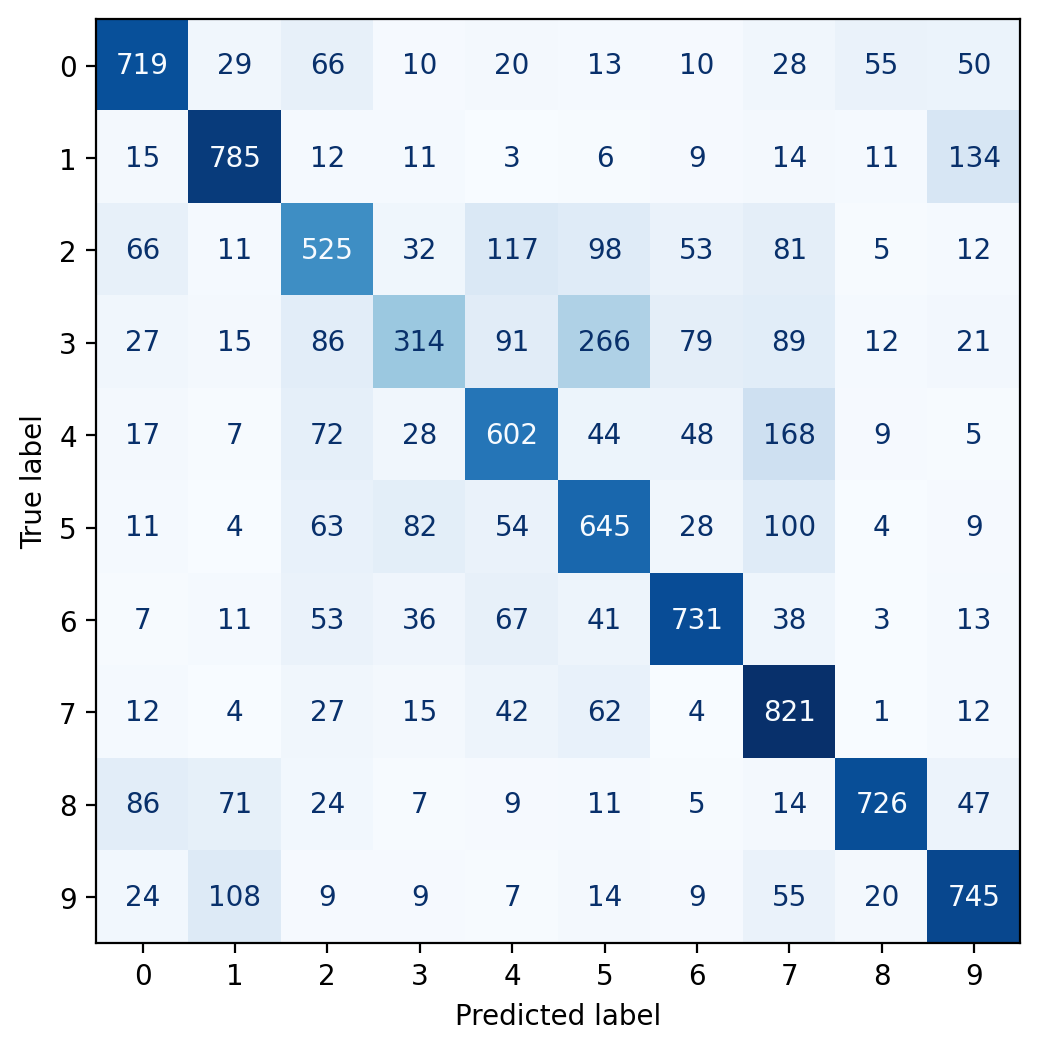

In [14]:
vgg_block_labels = [ ]
vgg_block_preds = [ ]

vgg_block.eval()
with torch.no_grad():
    for x_val, y_val in test_dataloader:
        x_val, y_val = x_val.to(device), y_val.to(device)
        y_pred = vgg_block(x_val)
        preds = torch.argmax(y_pred, dim = -1)
        vgg_block_preds.extend(preds.cpu().numpy())
        vgg_block_labels.extend(y_val.cpu().numpy())

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(vgg_block_labels, vgg_block_preds, cmap = plt.cm.Blues, ax = ax, colorbar = False)
plt.show()

In [15]:
print(classification_report(vgg_block_labels, vgg_block_preds))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1000
           1       0.75      0.79      0.77      1000
           2       0.56      0.53      0.54      1000
           3       0.58      0.31      0.41      1000
           4       0.59      0.60      0.60      1000
           5       0.54      0.65      0.59      1000
           6       0.75      0.73      0.74      1000
           7       0.58      0.82      0.68      1000
           8       0.86      0.73      0.79      1000
           9       0.71      0.74      0.73      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


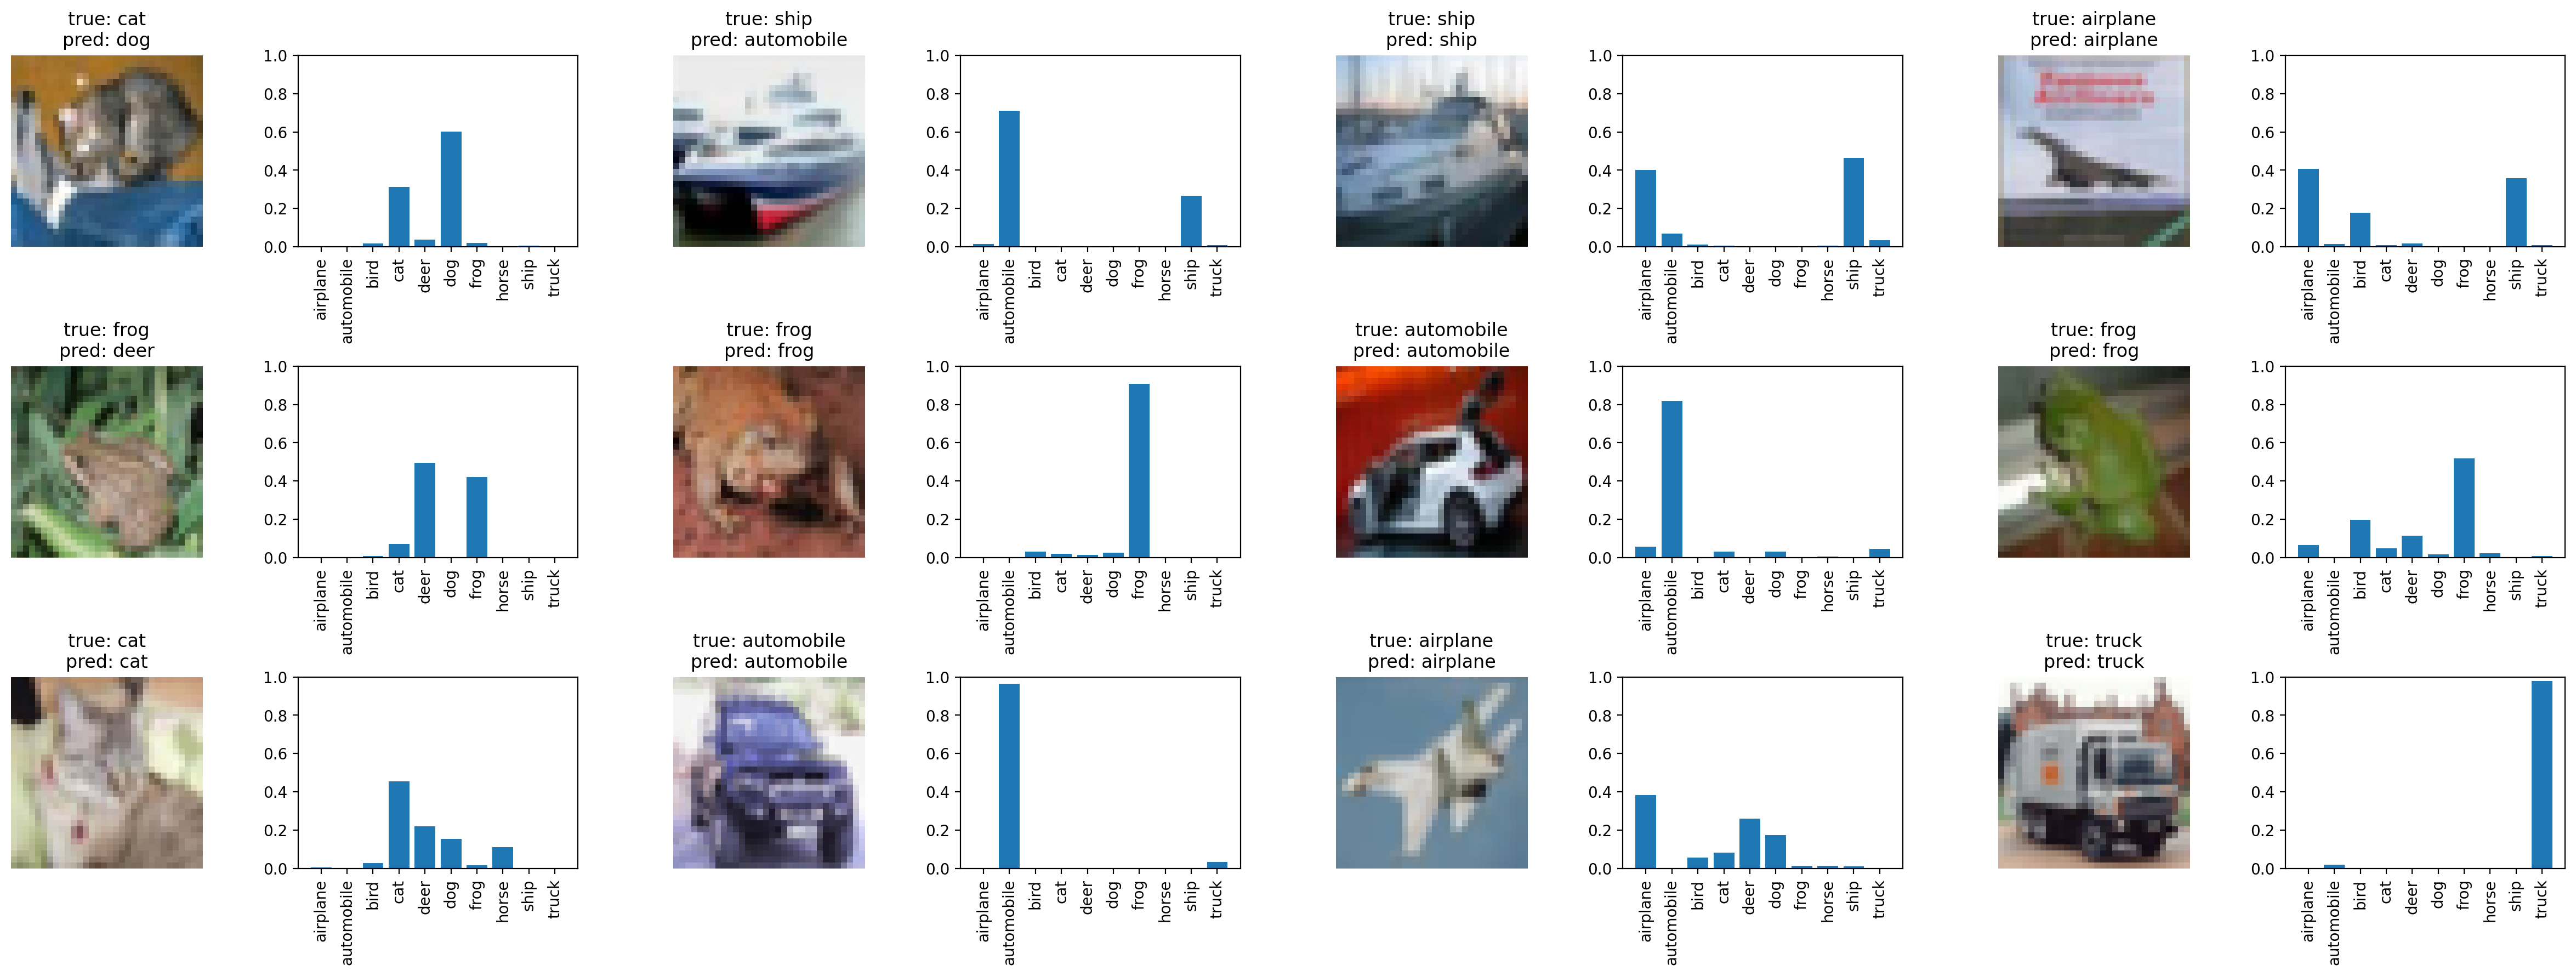

In [16]:
vgg_block.eval()
num_rows = 3
num_cols = 4
num_images = num_rows * num_cols

fig, axes = plt.subplots(num_rows, num_cols * 2, figsize=(3 * num_cols * 2, 3 * num_rows))
images_shown = 0

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vgg_block(x_batch)
        probs_batch = F.softmax(outputs, dim=1)

        for i in range(x_batch.size(0)):
            if images_shown >= num_images:
                break

            x_img = x_batch[i].cpu().permute(1,2,0)
            x_img = x_img * torch.tensor([0.247, 0.243, 0.261]) + torch.tensor([0.4914, 0.4822, 0.4465])
            x_img = x_img.clamp(0,1)

            probs = probs_batch[i].cpu().numpy()
            pred_class = probs.argmax()
            true_class = y_batch[i].item()

            row = images_shown // num_cols
            col = (images_shown % num_cols) * 2

            axes[row, col].imshow(x_img)
            axes[row, col].set_title(f'true: {classes[true_class]}\npred: {classes[pred_class]}')
            axes[row, col].axis('off')

            axes[row, col+1].bar(range(10), probs)
            axes[row, col+1].set_xticks(range(10))
            axes[row, col+1].set_xticklabels(classes, rotation=90)
            axes[row, col+1].set_ylim(0,1)

            images_shown += 1
        if images_shown >= num_images:
            break

plt.tight_layout()
plt.show()

In [17]:
class VGG_16(nn.Module):

    def __init__(self):
        super().__init__()

        self.vgg_block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.vgg_block2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.vgg_block3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.vgg_block4 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.vgg_block5 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 512 * 1 * 1, out_features = 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 4096, out_features = 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 4096, out_features = 10),
        )


    def forward(self, x):
        x = self.vgg_block1(x)
        x = self.vgg_block2(x)
        x = self.vgg_block3(x)
        x = self.vgg_block4(x)
        x = self.vgg_block5(x)
        x = self.fc_layers(x)
        return x

In [18]:
vgg16 = VGG_16().to(device)

In [19]:
optimizer = optim.SGD(vgg16.parameters(), lr = 0.001, momentum = 0.9)

Training vgg16 model with 33646666 parameters


Epoch 1/20:   0%|          | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: validation loss = 1.0675, validation accuracy = 0.6192


Epoch 2/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: validation loss = 0.6935, validation accuracy = 0.7587


Epoch 4/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: validation loss = 0.6080, validation accuracy = 0.7950


Epoch 6/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: validation loss = 0.5079, validation accuracy = 0.8299


Epoch 8/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: validation loss = 0.4829, validation accuracy = 0.8401


Epoch 10/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11: validation loss = 0.4742, validation accuracy = 0.8418


Epoch 12/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13: validation loss = 0.4378, validation accuracy = 0.8509


Epoch 14/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15: validation loss = 0.4824, validation accuracy = 0.8481


Epoch 16/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17: validation loss = 0.4876, validation accuracy = 0.8453


Epoch 18/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19: validation loss = 0.4316, validation accuracy = 0.8631


Epoch 20/20:   0%|          | 0/1250 [00:00<?, ?it/s]

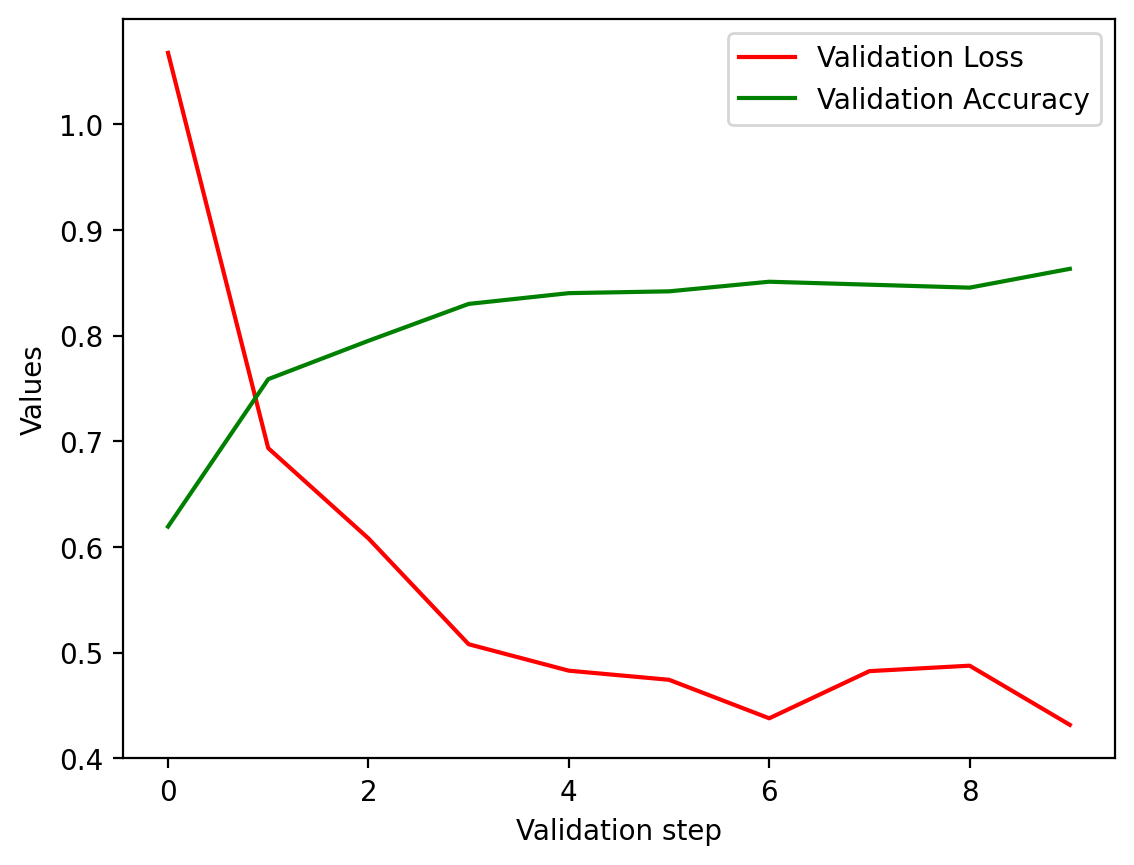

In [20]:
print(f'Training vgg16 model with {sum([x[1].numel() for x in vgg16.named_parameters()])} parameters')
train(vgg16, train_dataloader, test_dataloader, optimizer, device, epochs = 20)

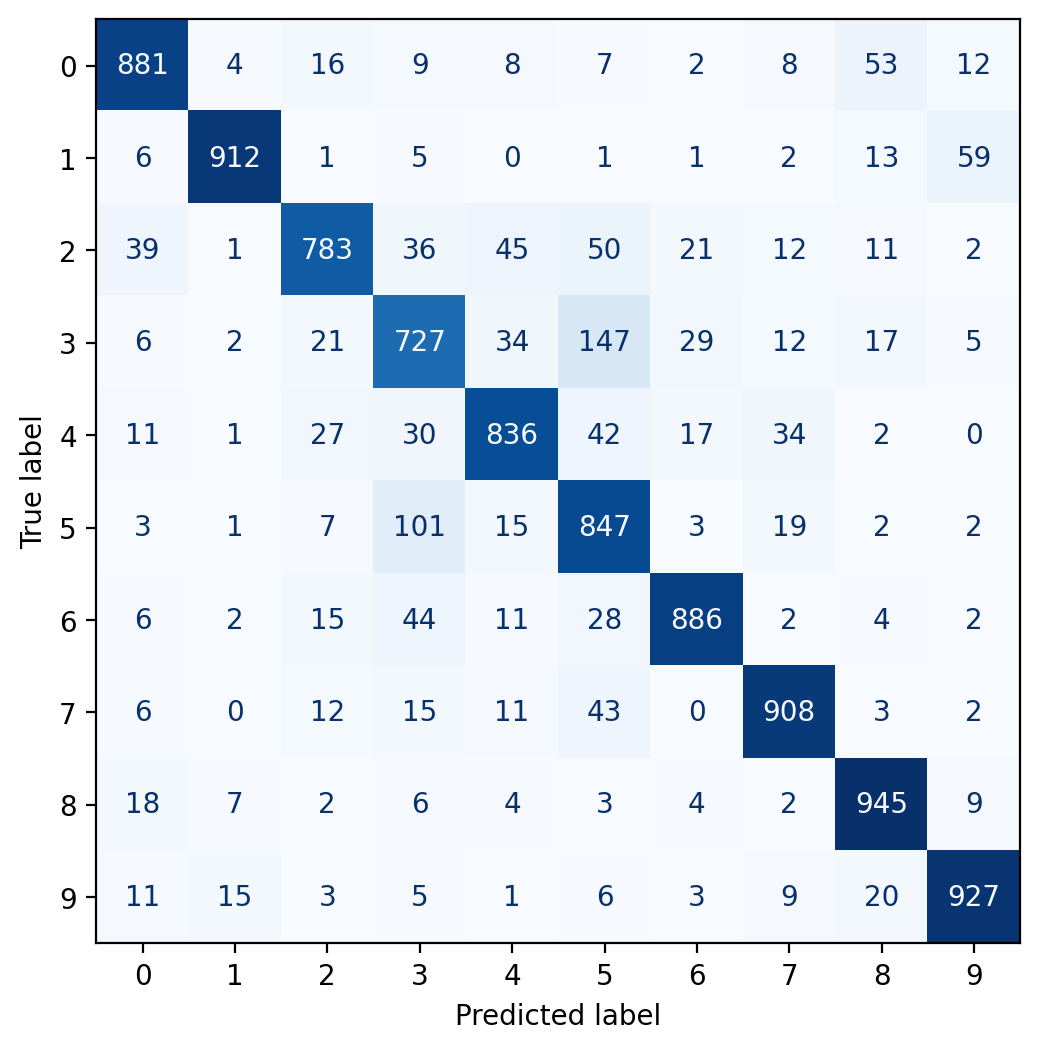

In [21]:
vgg16_preds = [ ]
vgg16_labels = [ ]

vgg16.eval()
with torch.no_grad():
    for x_val, y_val in test_dataloader:
        x_val, y_val = x_val.to(device), y_val.to(device)
        y_pred = vgg16(x_val)
        preds = torch.argmax(y_pred, dim = -1)
        vgg16_preds.extend(preds.cpu().numpy())
        vgg16_labels.extend(y_val.cpu().numpy())

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(vgg16_labels, vgg16_preds, cmap = plt.cm.Blues, ax = ax, colorbar = False)
plt.show()

In [22]:
print(classification_report(vgg16_labels, vgg16_preds))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1000
           1       0.97      0.91      0.94      1000
           2       0.88      0.78      0.83      1000
           3       0.74      0.73      0.74      1000
           4       0.87      0.84      0.85      1000
           5       0.72      0.85      0.78      1000
           6       0.92      0.89      0.90      1000
           7       0.90      0.91      0.90      1000
           8       0.88      0.94      0.91      1000
           9       0.91      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


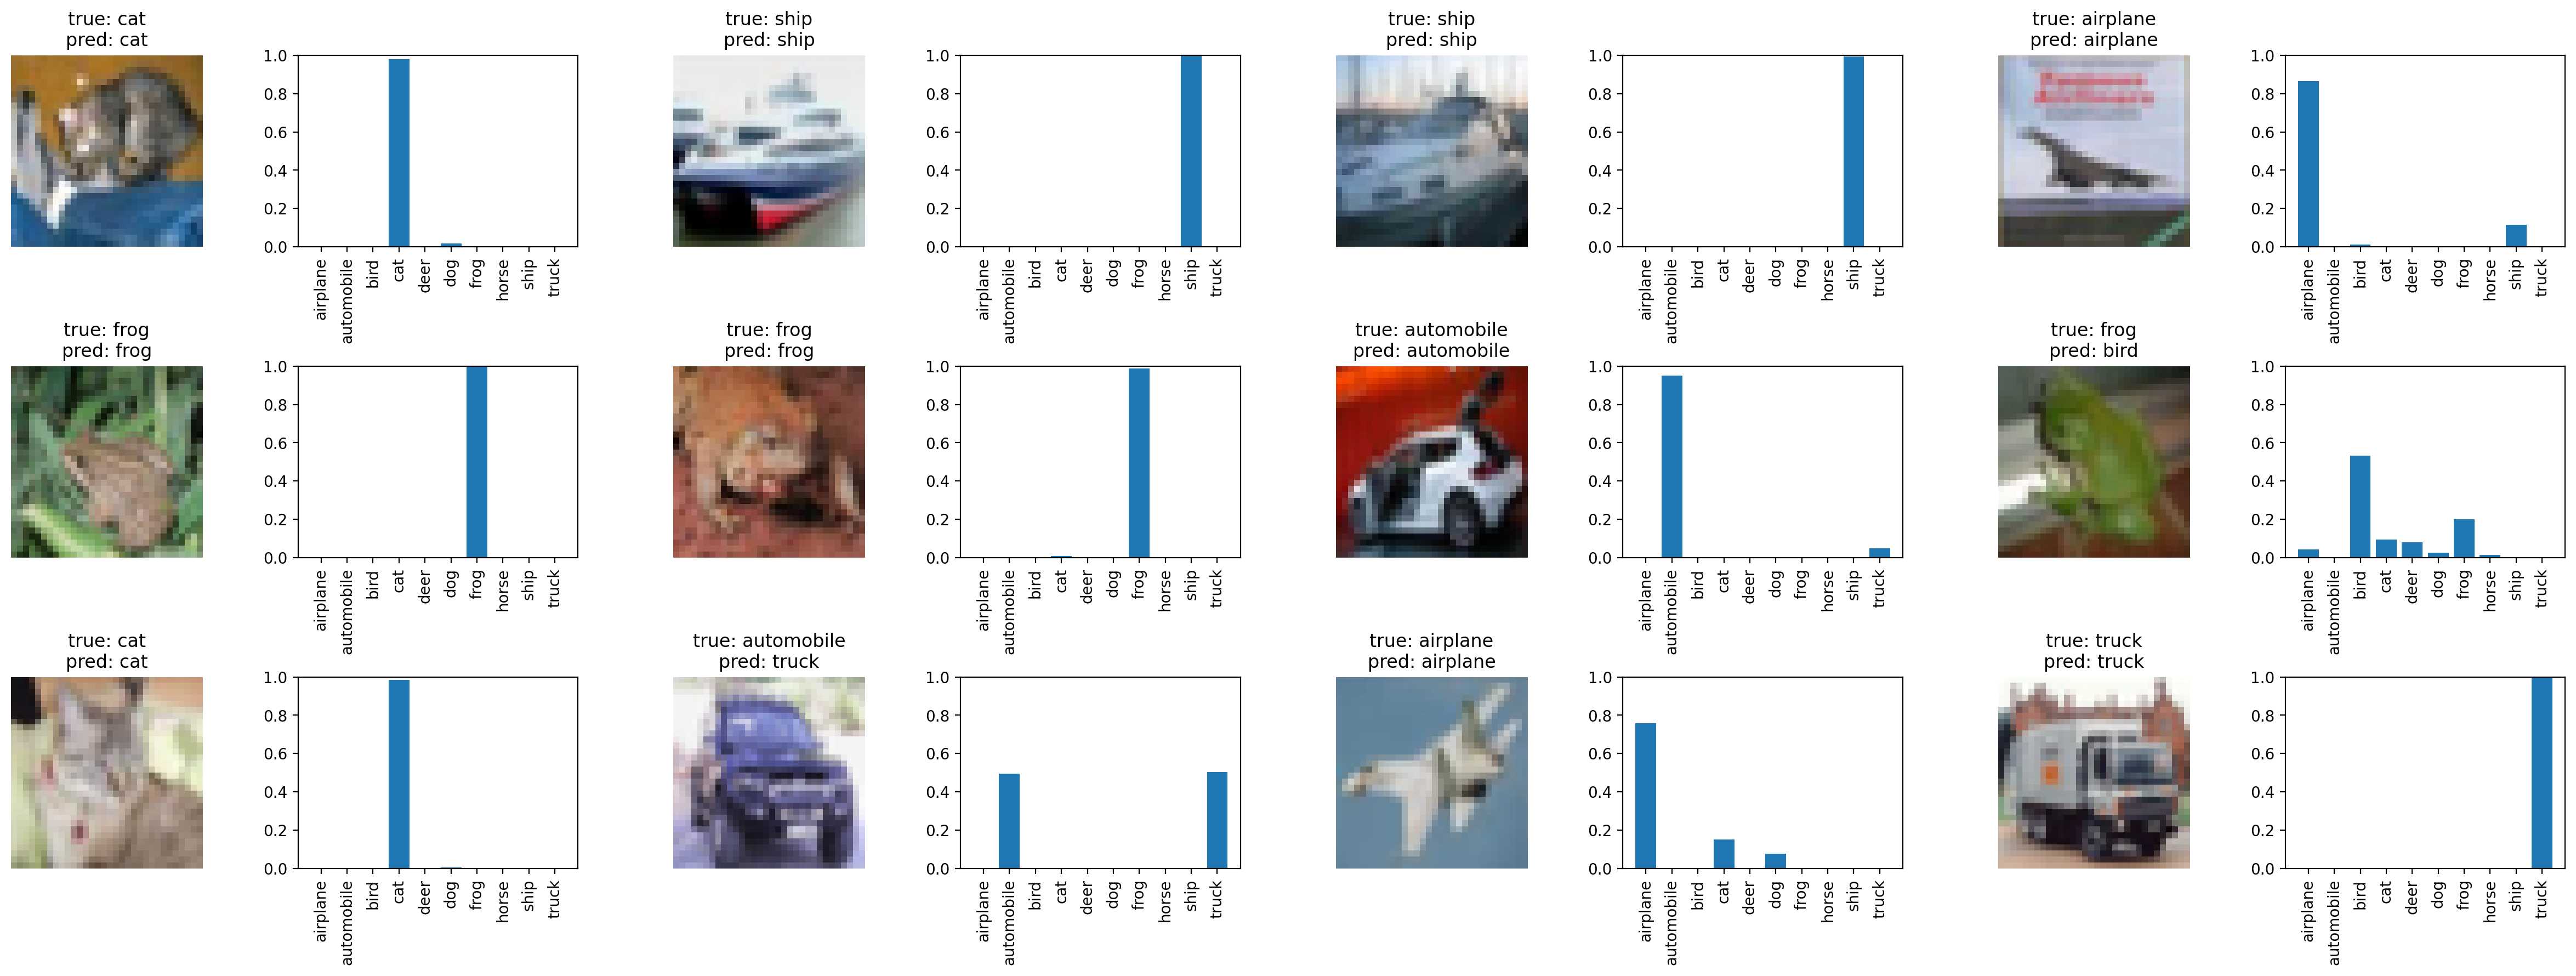

In [23]:
vgg16.eval()

num_rows = 3
num_cols = 4
num_images = num_rows * num_cols
fig, axes = plt.subplots(num_rows, num_cols * 2, figsize=(3 * num_cols * 2, 3 * num_rows))
images_shown = 0

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = vgg16(x_batch)
        probs_batch = F.softmax(outputs, dim = 1)

        for i in range(x_batch.size(0)):
            if images_shown >= num_images:
                break

            x_img = x_batch[i].cpu().permute(1,2,0)
            x_img = x_img * torch.tensor([0.247, 0.243, 0.261]) + torch.tensor([0.4914, 0.4822, 0.4465])
            x_img = x_img.clamp(0,1)

            probs = probs_batch[i].cpu().numpy()
            pred_class = probs.argmax()
            true_class = y_batch[i].item()

            row = images_shown // num_cols
            col = (images_shown % num_cols) * 2

            axes[row, col].imshow(x_img)
            axes[row, col].set_title(f'true: {classes[true_class]}\npred: {classes[pred_class]}')
            axes[row, col].axis('off')

            axes[row, col+1].bar(range(10), probs)
            axes[row, col+1].set_xticks(range(10))
            axes[row, col+1].set_xticklabels(classes, rotation = 90)
            axes[row, col+1].set_ylim(0,1)

            images_shown += 1
        if images_shown >= num_images:
            break

plt.tight_layout()
plt.show()